# Final project

In [1]:
import sqlite3 as sql
import pandas as pd
import plotly.express as px
import numpy as np
from scipy.stats import zscore
import plotly.io as pio

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

### Graph the number of accidents across time
##### Get the data using sqlite3 module

In [2]:
# get the data with sqlite
con = sql.connect("switrs.sqlite")
cur = con.cursor()

query1 = """SELECT strftime('%Y-%m',collision_date) AS date, strftime('%Y', collision_date) as year, 
COUNT(collision_date) as count 
FROM collisions 
WHERE strftime('%Y', collision_date) != '2021' 
GROUP BY date 
ORDER BY date"""

data = pd.read_sql(query1, con)

##### Create the plot using plotly

In [3]:
pio.renderers.default = 'plotly_mimetype'

fig = px.line(data, x="date", y ="count", title="Accidents in California from 2001 to 2020",
              labels={
                  "date":"month and year of accident",
                  "count":"accident frequency"
              })
fig.update_layout(xaxis=dict(tickmode="array", tickvals=data['date'][::12], ticktext=data['year'][::12]))
fig.update_traces(hovertemplate="%{x|%b %Y}")
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=6, step="month", label="6 months", stepmode="backward"),
                      dict(count=1, step="year", label="1 year", stepmode="backward"),
                      dict(count=5, step="year", label="5 years", stepmode="backward"),
                      dict(step="all")
                      
                      ])
    )
)
fig.show()

### Graph the frequency of collision severity
##### Get the data using sqlite

In [4]:
query2 = """
SELECT strftime('%Y', collision_date) as year, collision_severity, 
COUNT(collision_severity) as severity_count 
FROM collisions 
WHERE strftime('%Y',collision_date) != '2021' 
AND collision_severity != 'N' 
GROUP BY year, collision_severity
"""

data2 = pd.read_sql(query2,con)
pd.options.display.max_rows=10
display(data2)


,year,collision_severity,severity_count
0,2001,fatal,3517
1,2001,other injury,70052
2,2001,pain,120748
3,2001,property damage only,317567
4,2001,severe injury,10678
...,...,...,...
95,2020,fatal,3419
96,2020,other injury,48293
97,2020,pain,81694
98,2020,property damage only,219873


##### Create the histogram using plotly

In [5]:

pio.renderers.default = 'plotly_mimetype'

fig2 = px.histogram(data2, x='year', y='severity_count', barmode="group",
              color='collision_severity', 
              title="Severity of accidents from 2001 to 2020",
              labels= {
                  'year': 'Year',
                  'severity_count': 'Frequency',
                  'collision_severity': 'Collision Severity'
              })
fig2.show()

### Build neural network that predicts accident severity

The next part of this assignment will be about building a neural network which can predict severity type.

Features to include:
- collision_time
- day_of_week
- chp_beat_type (location of crash)
- distance (distance of the crash from the intersection with secondary road)
- direction (of crash)
- weather1
- party_count (num of vehicle involved in crash)
- primary_coll_factor
- type_of_collision
- motor_vehicle_involved_with
- road_surface
- road_cond_1
- lighting
- bicycle_accident
- motorcycle_accident
- truck_accident

##### Get the data using sqlite


In [6]:
queryNN = """
SELECT collision_severity,
collision_time,
strftime('%Y', collision_date) as year,
strftime('%m', collision_date)as month,
chp_beat_type,
distance,
weather_1,
party_count,
primary_collision_factor,
type_of_collision,
motor_vehicle_involved_with,
road_surface,
road_condition_1,
lighting,
bicycle_collision,
motorcycle_collision,
truck_collision
FROM collisions
ORDER BY RANDOM()
LIMIT 10000
"""

dataNN = pd.read_sql(queryNN,con)
#dataNN_use = dataNN.sample(frac=1)
display(dataNN)

,collision_severity,collision_time,year,month,chp_beat_type,distance,weather_1,party_count,primary_collision_factor,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,bicycle_collision,motorcycle_collision,truck_collision
0,property damage only,02:36:00,2015,02,not chp,50.0,clear,1,vehicle code violation,hit object,fixed object,dry,normal,dark with street lights,0,0,0
1,property damage only,13:10:00,2002,06,interstate,120.0,cloudy,2,vehicle code violation,sideswipe,other motor vehicle,dry,normal,daylight,0,0,0
2,pain,19:55:00,2018,06,county road area,500.0,clear,3,vehicle code violation,sideswipe,other motor vehicle,dry,normal,dark with street lights,0,0,0
3,other injury,16:25:00,2015,06,not chp,0.0,cloudy,2,vehicle code violation,broadside,other motor vehicle,dry,normal,daylight,0,0,0
4,property damage only,11:00:00,2011,07,not chp,85.0,clear,2,vehicle code violation,sideswipe,other motor vehicle,dry,normal,daylight,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,property damage only,18:10:00,2007,07,not chp,15.0,clear,2,vehicle code violation,sideswipe,other motor vehicle,dry,normal,dusk or dawn,0,0,0
9996,property damage only,12:10:00,2014,12,state route,2600.0,clear,2,vehicle code violation,sideswipe,other motor vehicle,dry,normal,daylight,0,0,1
9997,pain,08:20:00,2004,12,not chp,141.0,clear,2,vehicle code violation,rear end,other motor vehicle,dry,normal,daylight,0,0,0
9998,pain,07:35:00,2004,01,county road line,53.0,clear,1,other than driver,hit object,fixed object,snowy,normal,daylight,0,0,0


##### Shuffle the data and pick the number of data points to use

In [7]:
# dataNN_use = dataNN.sample(frac=1, random_state=1)[:500]
# display(dataNN_use)

In [8]:
# Clean the data
# dataNN_use.isnull().sum()

##### Get the hour of the day and transform to float

In [9]:
# get hour of day
dataNN["collision_time"] = dataNN["collision_time"].str.split(":").str[0].astype(float)
# dataNN_use["collision_time"] = dataNN_use["collision_time"].str.split(":").str[0].astype(float)
#dataNN["collision_time"][1][0:2]
# make year 

In [10]:

print(dataNN.dtypes)
pd.options.display.max_rows=20

collision_severity       object
collision_time          float64
year                     object
month                    object
chp_beat_type            object
                         ...   
road_condition_1         object
lighting                 object
bicycle_collision         int64
motorcycle_collision      int64
truck_collision           int64
Length: 17, dtype: object


##### One hot encode categorical variables

In [11]:
# one hot encode variables
data_rows_encode = ["year","month","chp_beat_type", "weather_1","primary_collision_factor", 
               "type_of_collision", "motor_vehicle_involved_with", "road_surface",
               "road_condition_1","lighting"]


data_dummies = pd.get_dummies(dataNN[data_rows_encode])
label_dummies = pd.get_dummies(dataNN["collision_severity"])

display(data_dummies)
display(label_dummies)

,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,...,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
9996,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
9997,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
9998,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


,fatal,other injury,pain,property damage only,severe injury
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,True,False,False
3,False,True,False,False,False
4,False,False,False,True,False
...,...,...,...,...,...
9995,False,False,False,True,False
9996,False,False,False,True,False
9997,False,False,True,False,False
9998,False,False,True,False,False


##### Create df with data to use and transform into matrix

In [12]:
# frop rows that were one hot encoded and the labels and merge df with dummie variables
final_data = dataNN.drop(data_rows_encode + ["collision_severity"],axis=1).merge(data_dummies,left_index=True, right_index=True)

# fill na's for collision time with the mean
final_data["collision_time"] = final_data["collision_time"].fillna(value=np.mean(final_data["collision_time"]))

# normalize the numeric variables (collision_time, distance, party_count)
numerical = ["collision_time", "distance", "party_count"]
final_data[numerical] = final_data[numerical].apply(zscore)

#print(final_data[:10])

# transform df to array
data_array_NN = final_data.to_numpy()
labels_array_NN = label_dummies.to_numpy()
print(labels_array_NN.shape)
print(data_array_NN.shape)

(10000, 5)
(10000, 95)


##### Build neural network

In [13]:
# get testing and training set
from sklearn.model_selection import train_test_split
data_array_NN = np.array(data_array_NN).astype(np.float32)
labels_array_NN = np.array(labels_array_NN).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(data_array_NN, labels_array_NN, train_size=0.7)

print(X_train.shape)

(7000, 95)


In [14]:
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import regularizers

# def build_neural_net(input_size, hidden_nodes, num_classes):
#     # Create a sequential model object
#     model = models.Sequential()

#     # Create the hidden layer with sigmoid activations
#     model.add(layers.Dense(units=hidden_nodes, activation='sigmoid', input_shape=(input_size,)))
    
#     # Create the output layer with softmax activations
#     model.add(layers.Dense(units=num_classes, activation='softmax'))
    
#     # Compile the network with the appropriate loss function and keep track of accuracy
#     model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    
#     return model

In [15]:
# model = build_neural_net(X_train.shape, 64, num_classes)

# # Flat
# x_train_flat = x_train.reshape(x_train.shape[0], image_size)
# x_test_flat = x_test.reshape(x_test.shape[0], image_size)

# # Train our model
# history = model.fit(x_train_flat, y_train, batch_size=128, epochs=10, validation_split=.1)

# # See how the model scored!
# loss, accuracy  = model.evaluate(x_test_flat, y_test)

# # Print to 3 decimals
# print(f'Test loss: {loss:.3}')
# print(f'Test accuracy: {accuracy:.3}')

(7000, 95)


c:\Users\miade\miniconda3\envs\SP\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3437 - loss: 6.2536 - val_accuracy: 0.6214 - val_loss: 5.2669
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5512 - loss: 5.1879 - val_accuracy: 0.6186 - val_loss: 4.6348
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5951 - loss: 4.5417 - val_accuracy: 0.6200 - val_loss: 4.1308
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6181 - loss: 4.0259 - val_accuracy: 0.6229 - val_loss: 3.7128
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6122 - loss: 3.6235 - val_accuracy: 0.6286 - val_loss: 3.3129
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6144 - loss: 3.2147 - val_accuracy: 0.6300 - val_loss: 2.9615
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6209 - loss: 2.8796 - val_accuracy: 0.6371 - val_loss: 2.6376
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6310 - loss: 2.5691 - val_accuracy: 0.6414 - val_loss:

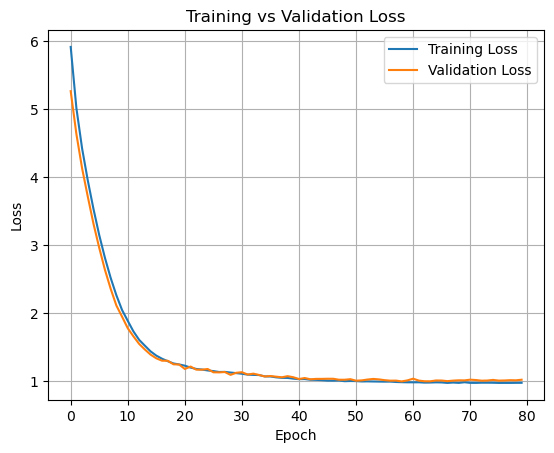

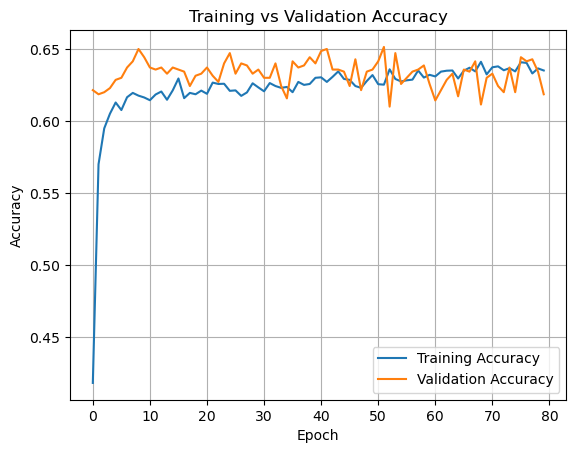

In [16]:
print(X_train.shape)
model = models.Sequential()

# Create the hidden layer with sigmoid activations
model.add(layers.Dense(units=100, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.4))
model.add(layers.Dense(units=200, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=200, kernel_regularizer=regularizers.L1(0.001),
                     activation='relu'))
model.add(layers.BatchNormalization())

# Create the output layer with softmax activations
model.add(layers.Dense(units=5, activation='softmax'))

# Compile the network with the appropriate loss function and keep track of accuracy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Train our model
history = model.fit(X_train, y_train, batch_size=100, epochs=80, validation_split=.1)

# See how the model scored!
loss, accuracy  = model.evaluate(X_test, y_test)

# Print to 3 decimals
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')


import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()